In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model

In [2]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [3]:
import pandas as pd
def getData(filename):
    chunksize = 1200000
    flag =1
    for data in pd.read_csv(filename, sep=",", chunksize=chunksize):
        while flag<2 and chunksize < 1200000:
            print(data)
        flag+=1
    print(data.head())
    print(list(data.columns.values))
    print(type(data))
    
    return data

In [4]:
import random
filename = '../shot_listed_dataset/CoverTypeNewNormalized.csv'
dataset=getData(filename).values.tolist()
random.shuffle(dataset)
dataset=pd.DataFrame(dataset) #from dataset_list to dataset_dataframe after suffling
# print(dataset)

   Elevation    Aspect     Slope  Horizontal_Distance_To_Hydrology  \
0   0.850622  0.105556  0.150943                          0.045351   
1   0.879149  0.163889  0.188679                          0.426304   
2   0.767116  0.327778  0.320755                          0.068027   
3   0.791494  0.338889  0.226415                          0.294785   
4   0.867220  0.575000  0.584906                          0.385488   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                       -0.003509                         0.631060   
1                        0.189474                         0.177358   
2                        0.038596                         0.259652   
3                       -0.077193                         0.085486   
4                        0.314035                         0.074020   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0       0.866142        0.874016          0.548   
1       0.897638        0.866142          0.500   
2    

In [5]:
X=dataset.iloc[:,0:-1]
y=dataset.iloc[:,-1]

In [6]:
def split_data(data):
    # splitting the data
    
    msk = np.random.rand(len(data)) < 0.9
    yy = [54] #test title is 54 after suffleing the dataframe 
    train = data[msk]
    test = data[~msk]
    x_train = train[train.columns[:train.shape[1] - 1]]  # all columns except the last are x variables
    y_train = train[yy[0]].tolist()  # the last column as y variable
    x_test = test[test.columns[:test.shape[1] - 1]]
    y_test = test[yy[0]].tolist()  # the last column as y variable
    y_train = [0 if i == 7 else i for i in y_train]  # replace label 7 with 0
    y_test = [0 if i == 7 else i for i in y_test]  # replace label 7 with 0
    return x_train, y_train, x_test, y_test

In [7]:
X_train, y_train, X_test, y_test = split_data(dataset)

In [8]:
import pickle

# Load the encoder model from the saved file
with open("Encoder.pkl", "rb") as file: #"rb"= read mode
    encoder = pickle.load(file)

encoder


In [9]:
encoded_X = pd.DataFrame(encoder.predict(X))
encoded_X = encoded_X.add_prefix('feature_')

encoded_X_train = pd.DataFrame(encoder.predict(X_train))
encoded_X_train = encoded_X_train.add_prefix('feature_')

encoded_X_test = pd.DataFrame(encoder.predict(X_test))
encoded_X_test = encoded_X_test.add_prefix('feature_')



62/62 [==============================] - 0s 1ms/step


# tune_MLP

In [10]:
# train the model with random parameter
from sklearn.neural_network import MLPClassifier

model_MLP = MLPClassifier(
     hidden_layer_sizes=120,
     random_state=42,
     max_iter=300,
     solver="adam"

     
     
     
        
     )

model_MLP.fit(encoded_X_train, y_train)

MLPClassifier(hidden_layer_sizes=120, max_iter=300, random_state=42)

In [11]:
# Finding mean absolute error
preds = model_MLP.predict(encoded_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.6028659160696008

In [12]:
#Use Optuna to find the best hyperparameters
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
K = 5 # stratified 5 fold cross validation, The folds are made by preserving the percentage of samples for each class.
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)

train_tunned= np.array(encoded_X)
target_train_tunned= np.array(y)

oof_preds= np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective_MLP(trial):

 for train_index, val_index in (skf.split(encoded_X,y)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    param={
        'hidden_layer_sizes':trial.suggest_int("hidden_layer_sizes", 150, 500),
        # solver=trial.suggest_categorical("solver", ["lbfgs", "sgd", "adam"]),
        'learning_rate':trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"]),
        'random_state':trial.suggest_int("random_state",0, 10),
        'max_iter':trial.suggest_int("max_iter",100,1000),
        'activation':trial.suggest_categorical("activation", ["logistic", "tanh", "relu"]),
        'batch_size':trial.suggest_int("batch_size",2,20),
        'verbose':False
    }
    model=MLPClassifier(**param)
    model.fit(train_X, train_Y)
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X
 mae = mean_absolute_error(target_train_tunned, oof_preds)
 return mae

In [13]:
# this is the main optuna for optimizing a object-->"objective"
import optuna
study_MLP = optuna.create_study(direction='minimize',study_name="MLP_tunning")

[I 2024-02-08 16:19:45,659] A new study created in memory with name: MLP_tunning


In [14]:

study_MLP.optimize(objective_MLP, n_trials=5) 
print('Number of finished trials:', len(study_MLP.trials))
print('Best trial:', study_MLP.best_trial.params)

[I 2024-02-08 16:39:32,588] Trial 0 finished with value: 0.8017577617140776 and parameters: {'hidden_layer_sizes': 354, 'learning_rate': 'invscaling', 'random_state': 4, 'max_iter': 233, 'activation': 'tanh', 'batch_size': 6}. Best is trial 0 with value: 0.8017577617140776.
[I 2024-02-08 16:57:30,416] Trial 1 finished with value: 0.8035259243850434 and parameters: {'hidden_layer_sizes': 231, 'learning_rate': 'adaptive', 'random_state': 1, 'max_iter': 458, 'activation': 'logistic', 'batch_size': 19}. Best is trial 0 with value: 0.8017577617140776.
[I 2024-02-08 18:08:20,642] Trial 2 finished with value: 0.5973789588642155 and parameters: {'hidden_layer_sizes': 319, 'learning_rate': 'invscaling', 'random_state': 7, 'max_iter': 458, 'activation': 'relu', 'batch_size': 5}. Best is trial 2 with value: 0.5973789588642155.
[I 2024-02-08 18:36:16,155] Trial 3 finished with value: 0.7834000728066982 and parameters: {'hidden_layer_sizes': 225, 'learning_rate': 'invscaling', 'random_state': 10, '

Number of finished trials: 5
Best trial: {'hidden_layer_sizes': 319, 'learning_rate': 'invscaling', 'random_state': 7, 'max_iter': 458, 'activation': 'relu', 'batch_size': 5}


In [15]:
#evaluate the trial
print("Number of finished trials: ", len(study_MLP.trials))
print("Best trial:")
trial = study_MLP.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  5
Best trial:
  Value:  0.5973789588642155
  Params: 
    hidden_layer_sizes: 319
    learning_rate: invscaling
    random_state: 7
    max_iter: 458
    activation: relu
    batch_size: 5


In [16]:
from matplotlib import pyplot as plt
fig_study = optuna.visualization.plot_parallel_coordinate(study_MLP, params=["hidden_layer_sizes", "learning_rate","random_state","max_iter","batch_size"])
fig_study.show()

# fit tunned MLP

In [17]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train_MLP = np.array(encoded_X_train)
target_train_MLP= np.array(y_train)

test_MLP = np.array(encoded_X_test) # or test_Ada = np.array(X)


test_preds_MLP = np.zeros((len(test_MLP)))
oof_preds_MLP = np.zeros((len(train_MLP)))

for train_index, val_index in tqdm(skf.split(encoded_X_train,y_train), total=5):
    train_X, valid_X = train_MLP[train_index], train_MLP[val_index]
    train_y, valid_y = target_train_MLP[train_index], target_train_MLP[val_index]
    ada_params = study_MLP.best_trial.params
    model_MLP_2 = MLPClassifier(**ada_params,tol=.00001,early_stopping=True) # for early_stopping
    model_MLP_2.fit(train_X, train_y)
    # for train accuracy
    preds = model_MLP_2.predict(valid_X)
    oof_preds_MLP[val_index] = preds
    # for test accuracy
    preds = model_MLP_2.predict(test_MLP)
    test_preds_MLP += (preds)/5
print(np.abs(oof_preds_MLP-target_train_MLP).mean())

100%|██████████| 5/5 [14:07<00:00, 169.47s/it]

0.5986107091172215


In [23]:
import pickle
# model_tuned=MLPClassifier(**study_MLP.best_trial.params, verbose=False)
pickle.dump(model_MLP_2, open("all_pkl_file/all_tuned_model/Encoder_MLP_fitted.pkl", "wb"))

In [18]:
target_test_MLP = np.array(y_test)

In [19]:
from sklearn.metrics import accuracy_score
valid_Acc_MLP=accuracy_score(target_train_MLP,oof_preds_MLP)
print(valid_Acc_MLP)

# another technique for calculate test accuracy
test_Acc_MLP=accuracy_score(target_test_MLP,test_preds_MLP.round())
print(test_Acc_MLP)

0.7169319826338639
0.6427840327533265


In [21]:
train_Acc_MLP=model_MLP_2.score(encoded_X_train,y_train)
print(train_Acc_MLP)

0.727178002894356


In [22]:
test_Acc_MLP=model_MLP_2.score(encoded_X_test,y_test)
print(test_Acc_MLP)

0.7057318321392017


# Evaluation

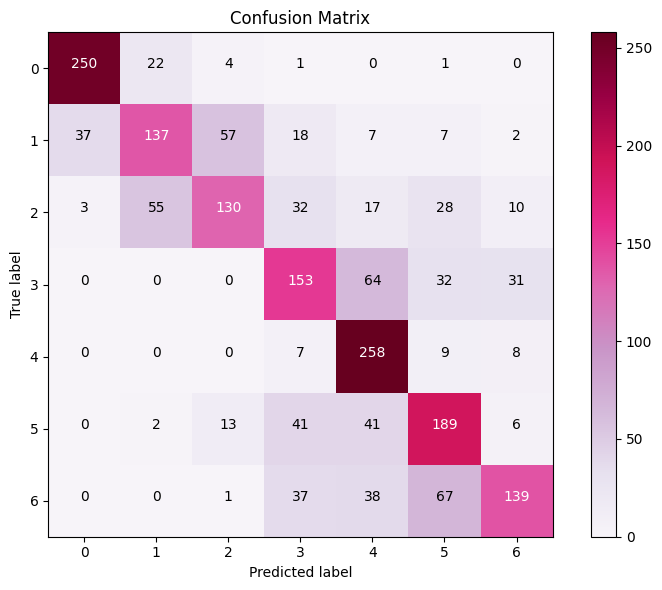

In [24]:
############# plot confusion matrix ############

from matplotlib import pyplot as plt
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds_MLP.round())
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()


# Learning _Curve


In [25]:
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier
################# it will take 0.8 as train data from the whole by-default ################
mlp = MLPClassifier(batch_size=11, hidden_layer_sizes=212, learning_rate='adaptive',random_state=5,max_iter=1000) #tuned MLP
train_sizes, train_scores, test_scores = learning_curve(mlp, encoded_X, y, train_sizes=np.linspace(0.1, 1.0, 5))

In [26]:
#***** Calculate mean and standard deviation of train and test scores (as we got values for 5 fold cross in each row****)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

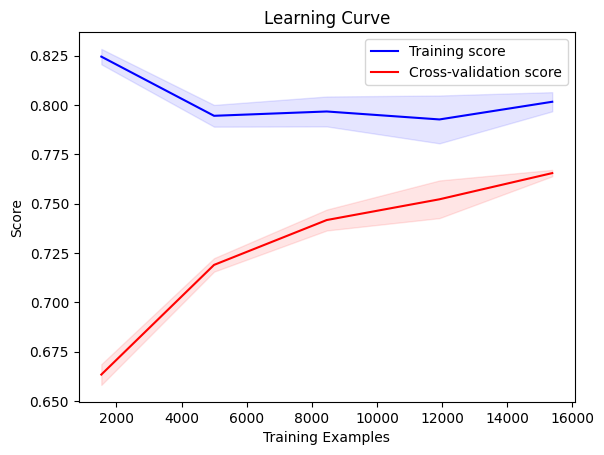

In [27]:
# Plot learning curves
plt.figure()
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1) #alpha=0.1: The transparency of the shaded region.
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='red')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.1)
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

**ROC_Curve**

In [28]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [29]:
# Binarize the output
y_train = label_binarize(y_train,classes=[0,1,2,3,4,5,6])
n_classes = y_train.shape[1]
print(n_classes)
print(y_train[0])

7
[1 0 0 0 0 0 0]


In [30]:
# Binarize the output (y_test)
y_test = label_binarize(y_test,classes=[0,1,2,3,4,5,6])
n_classes = y_test.shape[1]
print(n_classes)
print(y_test[0])

7
[0 0 0 0 0 1 0]


In [31]:
# Learn to predict each class against the other
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(batch_size=11, hidden_layer_sizes=212, learning_rate='adaptive',random_state=5,max_iter=500) #tuned MLP
classifier = OneVsRestClassifier(clf)

# Train the classifier
classifier.fit(encoded_X_train, y_train)

OneVsRestClassifier(estimator=MLPClassifier(batch_size=11,
                                            hidden_layer_sizes=212,
                                            learning_rate='adaptive',
                                            max_iter=500, random_state=5))

In [32]:
# Compute ROC curve and ROC area for each class
fpr = dict() #dictionary
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], classifier.predict_proba(encoded_X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

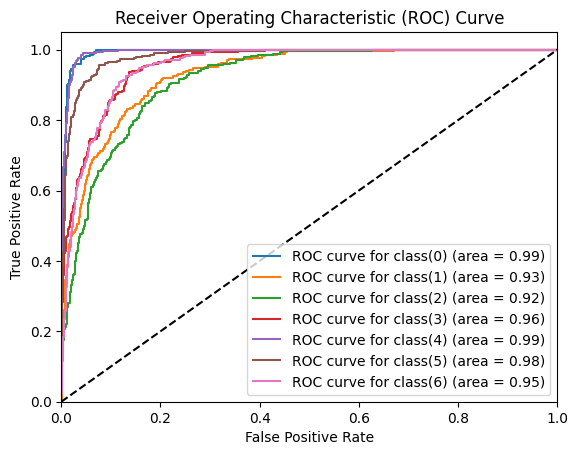

In [33]:
# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve for class(%i) (area = %0.2f)' % (i,roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="best")
plt.show()

**train_loss vs validation_score**

In [34]:
train_losses_ES=model_MLP_2.loss_curve_
print(len(train_losses_ES))

48


In [35]:
validation_score_ES=model_MLP_2.validation_scores_
print(len(validation_score_ES))

48


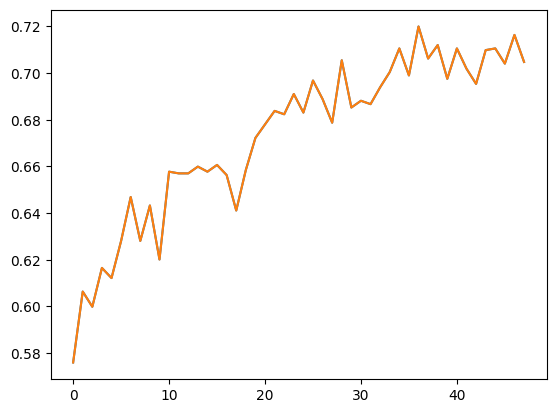

In [38]:
plt.figure()
plt.plot(range(len(validation_score_ES)), validation_score_ES, label="train_loss")
plt.plot(range(len(validation_score_ES)), validation_score_ES, label="validation_acc")
plt.show()